<h2> Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
sns.set_palette('Accent')

from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering


Book-Crossings dataset

Found here: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

Collected by Cai-Nicolas Ziegler in 2004. 278,858 users, 271,379 books, and 1,149,780 ratings.

This data was used in a publication:

Improving Recommendation Lists Through Topic Diversification,
Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; Proceedings of the 14th International World Wide Web Conference (WWW '05), May 10-14, 2005, Chiba, Japan. To appear.

In [2]:
## Loading the Data from Book-Crossings

df_books = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding = "latin-1")
df_users = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding = "latin-1")
df_ratings = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding = "latin-1")

# Renaming the columns so they are easier to work with in python
df_ratings.rename(columns={'User-ID': 'User', 'Book-Rating': 'Rating'}, inplace=True)
df_users.rename(columns={'User-ID': 'User'}, inplace=True)
df_books.rename(columns={'ISBN': 'ISBN', 'Book-Title': 'Title', 'Year-Of-Publication': 'Year', 'Book-Author': 'Author'}, inplace=True)
df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], 1, inplace=True) # I won't be using the image links

# Using only explicit ratings. 0 ratings are 'implicit' in documentation of data which basically means
# missing values so we can't work with them.
df_ratings = df_ratings[df_ratings['Rating'] > 0]

# Inner join df_ratings and df_books. This actually shortens the data quite a lot.
df_ratings = df_ratings[df_ratings['ISBN'].isin(df_books.ISBN.unique())]
df_books = df_books[df_books['ISBN'].isin(df_ratings.ISBN.unique())]

df_books.reset_index(inplace=True, drop=True)
df_ratings.reset_index(inplace=True, drop=True)
df_users.reset_index(inplace=True, drop=True)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:30

In [3]:
# Change year column to int
df_books = df_books[df_books['Year'].apply(lambda x: isinstance(x, int))]
df_books.reset_index(drop=True, inplace=True)
df_books = df_books.astype({'Year' : 'int32'})

avg_rating, num_ratings = [], []
for user in df_users.User:
    # This try - except clause is just one way of catching the users that haven't made any ratings
    try:
        avg_rating.append(np.mean(df_ratings.Rating[df_ratings.User == user]))
    except:
        avg_ratings.append(None)
    num_ratings.append(len(df_ratings[df_ratings.User == user]))
df_users['AverageRating'] = avg_rating
df_users['NumberRatings'] = num_ratings

df_users = df_users[df_users.NumberRatings > 0]
df_users.reset_index(inplace=True, drop=True)

<h2>Books

In [27]:
print('Number of Books', len(df_books))
print('Unique Authors:', len(df_books.Author.unique()))
print('Unique Publishers:', len(df_books.Publisher.unique()))
df_books.head()

Number of Books 124042
Unique Authors: 50939
Unique Publishers: 9745


,ISBN,Title,Author,Year,Publisher
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
3,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group


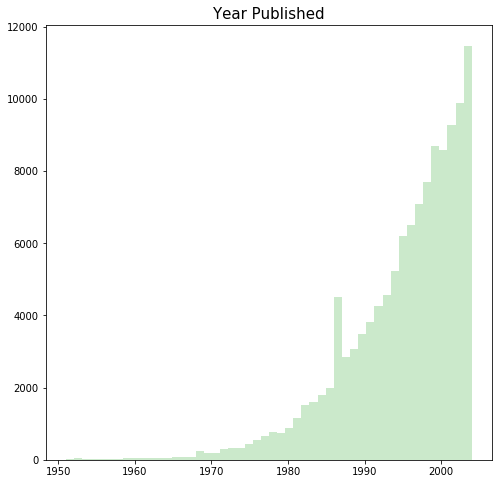

In [66]:
plt.figure(figsize=(8,8))
ax = sns.distplot(df_books.Year[(df_books.Year > 1950) & (df_books.Year < 2005)], axlabel=False, kde=False)
ax.set_title('Year Published', fontsize=15)
plt.show()

In [111]:
print('Number of books with publication year of 0:', len(df_books[df_books.Year == 0]))

Number of books with publication year of 0: 2238


Note: After scraping blurbs and cleaning, I ended up with only 57,000 books, a little less than a quarter of the original data. The above histogram cuts off a lot of outliers and erroneous dates. The data was scraped in 2004 so books with a publishing date after that are incorrect.

In [89]:
max_pub, max_aut = 0, 0
pub, aut = '', ''
for author in df_books.Author.unique():
    if len(df_books[df_books.Author == author]) > max_aut:
        max_aut = len(df_books[df_books.Author == author])
        aut = author
print('Most prolific author:', aut, 'with {} books'.format(max_aut))
for publisher in df_books.Publisher.unique():
    if len(df_books[df_books.Publisher == publisher]) > max_pub:
        max_pub = len(df_books[df_books.Publisher == publisher])
        pub = publisher
print('Publisher with most publications:', pub, 'with {} books'.format(max_pub))


Most prolific author: Stephen King with 420 books
Publisher with most publications: Harlequin with 2726 books


<h2>Users

In [29]:
df_users.iloc[:, :3].head()

,User,Location,Age
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
11,12,"fort bragg, california, usa",NaN
13,14,"mediapolis, iowa, usa",NaN
15,16,"albuquerque, new mexico, usa",NaN


I split up location into city, region, and country. Location is self-reported and very messy, but I don't use this as a feature in my models so I'll mostly ignore it for now.

In [30]:
city, region, country = [], [], []
for row in range(len(df_users)):
    split = df_users.Location.iloc[row].split(',')
    try:
        city.append(split[0])
    except:
        city.append(None)
    try:
        region.append(split[1])
    except:
        region.append(None)
    try:
        country.append(split[2])
    except:
        country.append(None)
df_users['City'] = city
df_users['Region'] = region
df_users['Country'] = country

In [74]:
print('Number of Users', len(df_users))
print('Unique cities:', len(df_users.City.unique()))
print('Unique regions:', len(df_users.Region.unique()))
print('Unique countries:', len(df_users.Country.unique()))

Number of Users 68091
Unique cities: 12272
Unique regions: 1609
Unique countries: 347


There are 195 actual countries in the world.

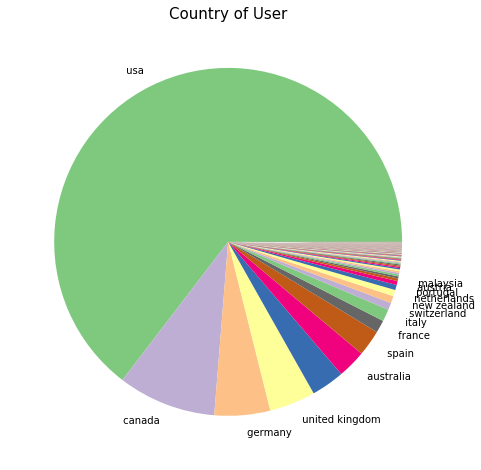

In [67]:
# Pie chart showing Country of User
size_dict, reverse_dict = {}, {}
for country in df_users.Country.unique():
    size_dict[country] = len(df_users[df_users.Country == country])
    reverse_dict[len(df_users[df_users.Country == country])] = country
sorted_values = sorted(size_dict.values(), reverse=True)

labels, sizes, i = [], [], 0
for size in sorted_values:
    sizes.append(size)
    labels.append(reverse_dict[size]) if i < 15 else labels.append('')
    i += 1
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels)
plt.title('Country of User', fontsize=15)
plt.show()

Most users in our dataset are from the USA, but Europe is also well represented. After browsing some of the less frequent responses, Asia, Africa, and South America are also all in the data but much less represented.

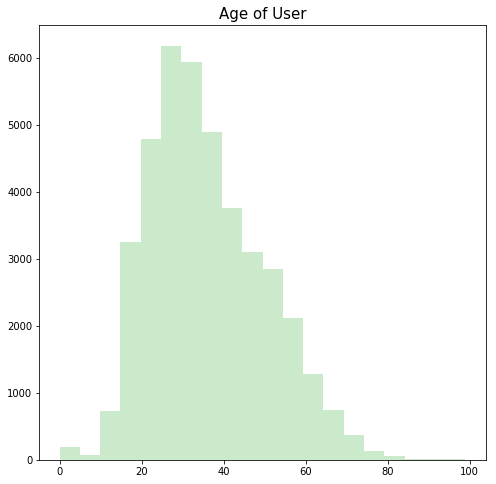

In [71]:
plt.figure(figsize=(8,8))
ax = sns.distplot(df_users.Age[df_users.Age < 100].dropna(), bins=20, kde=False, axlabel=False)
ax.set_title('Age of User', fontsize=15)
plt.show()

There are some very young users in this dataset, but in general our users are more concentrated at 20s and 30s than the general population. There were quite a few users reporting an age signficantly higher than 100 so I removed all of them.

- - -

<h2> Ratings </h2>
    
<p>This next table has all of the ratings each user made in our dataset from 1 - 10. Are there factors that affect the average rating a user makes? Rating scales are self-reported and could have different shapes for different users which could have implications for our recommender system.

In [72]:
df_ratings.head()

,User,ISBN,Rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276744,038550120X,7
4,276747,0060517794,9


In [76]:
print('Number of Ratings:', len(df_ratings))

Number of Ratings: 383842


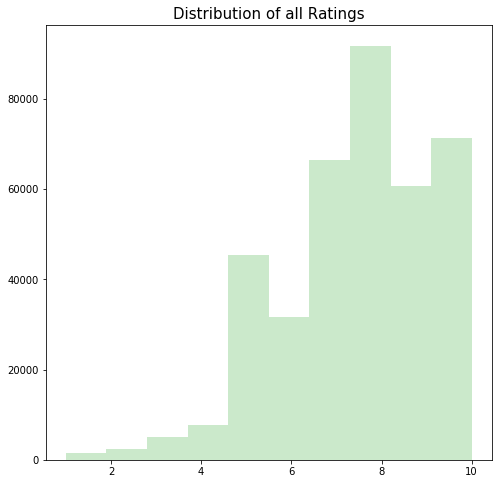

In [113]:
plt.figure(figsize=(8,8))
ax = sns.distplot(df_ratings.Rating, bins=10, kde=False, axlabel=False)
ax.set_title('Distribution of all Ratings', fontsize=15)
plt.show()

In [84]:
print('Overall Mean Rating:', np.mean(df_ratings.Rating))
print('Standard Deviation:', np.std(df_ratings.Rating))

Overall Mean Rating: 7.626700569505161
Standard Deviation: 1.841336961660986


Despite being a 1 - 10 scale, the mean rating is nowhere near 5. There are some interesting trends in this graph: People are more likely to rate something 5 and 8, and less likely to rate 6 or 9. The next graph explore if there is a relationship between the average rating a user makes and the number of ratings they make.

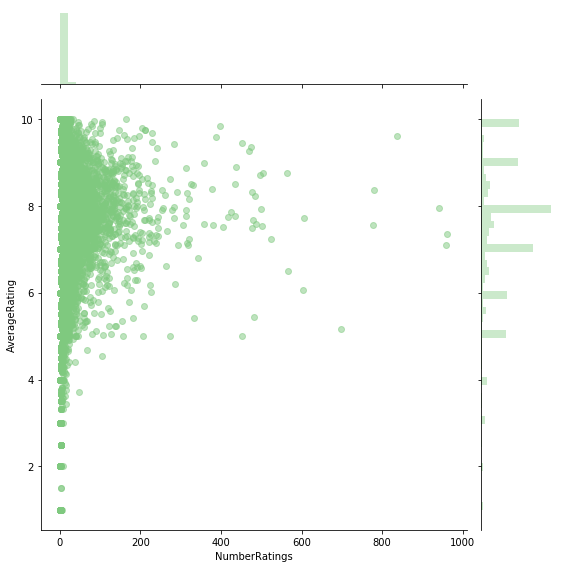

In [158]:
ax = sns.jointplot('NumberRatings', 'AverageRating', df_users[(df_users.NumberRatings < 1000)], alpha=0.5, ratio=5, height=8)
plt.show()

In [202]:
np.corrcoef(df_users[(df_users.NumberRatings < 1000)].NumberRatings, df_users[(df_users.NumberRatings < 1000)].AverageRating)

array([[1.        , 0.02106867],
       [0.02106867, 1.        ]])

Not a statistically significant between the number of ratings a user makes and the average rating they make.

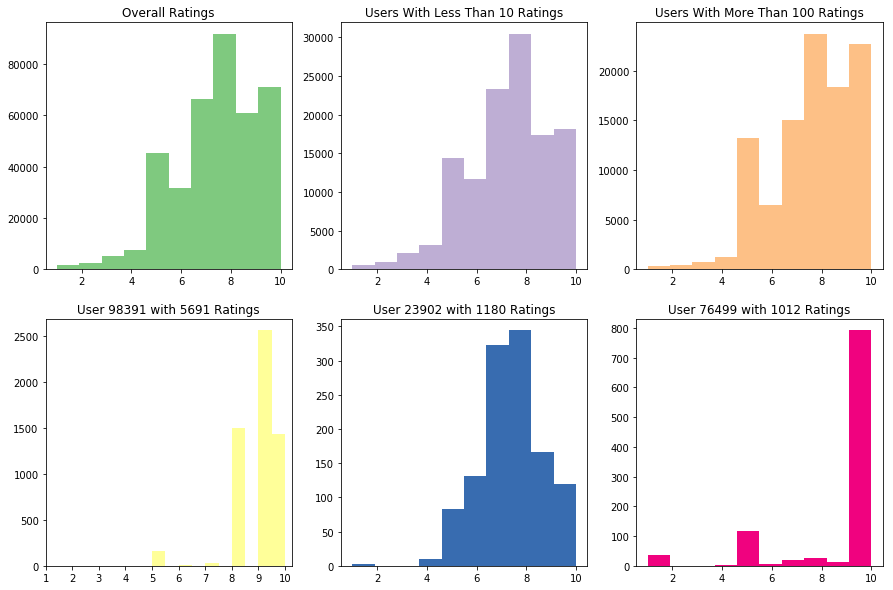

In [100]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].hist(df_ratings.Rating, color=sns.color_palette()[0])
axes[0, 1].hist(df_ratings.Rating[df_ratings.User.isin(df_users.User[df_users.NumberRatings < 10])], color=sns.color_palette()[1])
axes[0, 2].hist(df_ratings.Rating[df_ratings.User.isin(df_users.User[df_users.NumberRatings > 100])], color=sns.color_palette()[2])
axes[1, 0].hist(df_ratings.Rating[df_ratings.User == 98391], color=sns.color_palette()[3])
axes[1, 1].hist(df_ratings.Rating[df_ratings.User == 23902], color=sns.color_palette()[4])
axes[1, 2].hist(df_ratings.Rating[df_ratings.User == 76499], color=sns.color_palette()[5])

axes[1, 0].set_xticks(range(1, 11))

axes[0, 0].set_title('Overall Ratings')
axes[0, 1].set_title('Users With Less Than 10 Ratings')
axes[0, 2].set_title('Users With More Than 100 Ratings')
axes[1, 0].set_title('User 98391 with {} Ratings'.format(len(df_ratings[df_ratings.User == 98391])))
axes[1, 1].set_title('User 23902 with {} Ratings'.format(len(df_ratings[df_ratings.User == 23902])))
axes[1, 2].set_title('User 76499 with {} Ratings'.format(len(df_ratings[df_ratings.User == 76499])))
plt.show()

The first row of histograms is different groups of the full data, and the second row are each specific users from the dataset with an unusually high number of ratings. I might consider them outliers since they have made an unrealistic number of ratings, and the distribution of their ratings looks different from the general populations.

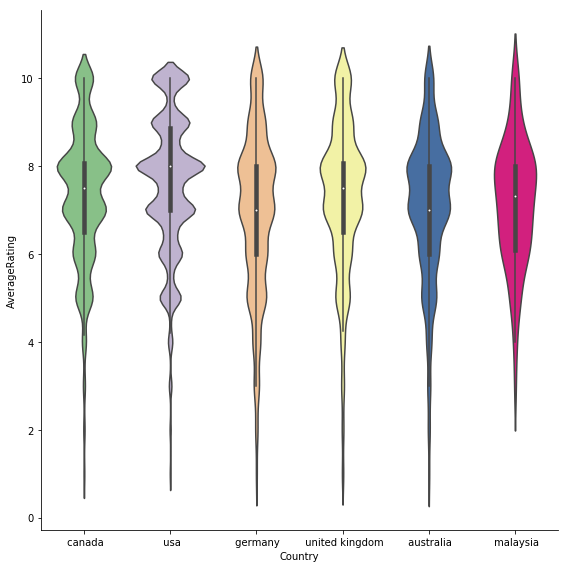

Canada mean: 7.36 	standard deviation: 1.58
USA mean: 7.61 		standard deviation: 1.57
Germany mean: 6.94 	standard deviation: 1.84
UK mean: 7.3 		standard deviation: 1.57
Australia mean: 7.1 	standard deviation: 1.57
Malaysia mean: 7.18 	standard deviation: 1.57


In [125]:
X = df_users[df_users.Country.isin([' usa', ' canada', ' germany', ' united kingdom',' australia', ' malaysia'])]
ax = sns.catplot(x="Country", y="AverageRating", data=X, kind='violin', height=8)
plt.show()
print('Canada mean:', round(np.mean(df_users.AverageRating[df_users.Country == ' canada']), 2), '\tstandard deviation:', round(np.std(df_users.AverageRating[df_users.Country == ' canada']), 2))
print('USA mean:', round(np.mean(df_users.AverageRating[df_users.Country == ' usa']), 2), '\t\tstandard deviation:', round(np.std(df_users.AverageRating[df_users.Country == ' usa']), 2))
print('Germany mean:', round(np.mean(df_users.AverageRating[df_users.Country == ' germany']), 2), '\tstandard deviation:', round(np.std(df_users.AverageRating[df_users.Country == ' germany']), 2))
print('UK mean:', round(np.mean(df_users.AverageRating[df_users.Country == ' united kingdom']), 2), '\t\tstandard deviation:', round(np.std(df_users.AverageRating[df_users.Country == ' usa']), 2))
print('Australia mean:', round(np.mean(df_users.AverageRating[df_users.Country == ' australia']), 2), '\tstandard deviation:', round(np.std(df_users.AverageRating[df_users.Country == ' usa']), 2))
print('Malaysia mean:', round(np.mean(df_users.AverageRating[df_users.Country == ' malaysia']), 2), '\tstandard deviation:', round(np.std(df_users.AverageRating[df_users.Country == ' usa']), 2))

Country does make a small difference. Germans are a bit more critical of books, and people from the USA are the most positive.

In [127]:
df_users_cleaned = df_users.dropna()[(df_users.Age < 100) & (df_users.Age > 5)].copy()
df_users_cleaned = df_users_cleaned[(df_users_cleaned.NumberRatings > 10) & (df_users_cleaned.NumberRatings < 1000)]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


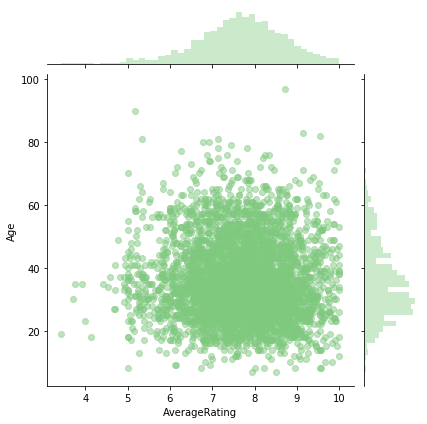

In [159]:
ax = sns.jointplot('AverageRating', 'Age', data=df_users_cleaned, alpha = 0.5)
plt.show()

Age and Average Rating seem profoundly unrelated.

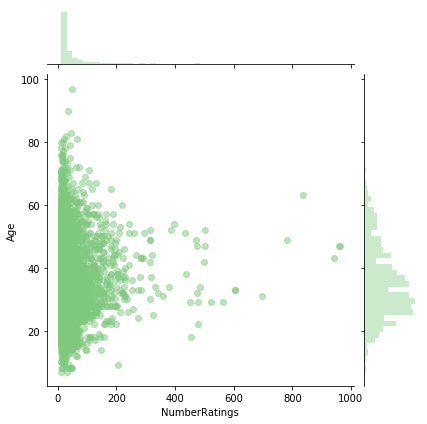

In [130]:
ax = sns.jointplot('NumberRatings', 'Age', data=df_users_cleaned, alpha = 0.5)
plt.show()

Similarly, no noticable relationship between Age and Number of Ratings 

In [160]:
books_with_blurbs_and_vectors = pd.read_csv('/DataScience/Final Capstone Files/books_with_blurbs_and_BERT_combined.csv')
books_with_blurbs_and_vectors.drop('Unnamed: 0', 1, inplace=True)
books_with_blurbs = books_with_blurbs_and_vectors.iloc[:, :6]

In [132]:
average_rating, number_ratings, popularity_score = [], [], []
global_mean_rating = np.mean(df_ratings.Rating)
for isbn in books_with_blurbs.ISBN:
    rating = np.mean(df_ratings.Rating[df_ratings.ISBN == isbn])
    number = len(df_ratings[df_ratings.ISBN == isbn])
    average_rating.append(rating)
    number_ratings.append(number)
    popularity_score.append(math.log(number) * (rating - global_mean_rating))
books_with_blurbs['AverageRating'] = average_rating
books_with_blurbs['NumberRatings'] = number_ratings
books_with_blurbs['PopularityScore'] = popularity_score

In [19]:
# Saving this table to a local csv so I can use it in other project notebooks
books_with_blurbs.to_csv('/DataScience/Final Capstone Files/books_with_popularities.csv', index=False)

Popularity Score is my homemade metric. A linear combination of the average rating and number of ratings does not provide the result I want. I will eventually use it to help recommend books, and it represents the 'best' book. By using the logarithm of the number of ratings, I achieve a few things. To illustrate this, imaging a book with an average rating of 8.6, which is 1 point above the global average rating and use the histogram below to compare:
1. With only 1 rating, this book has a score of 0 which means it is very unlikely for my system to recommend it. This makes sense since 1 rating isn't enough data to draw conclusions about the quality of a book.
2. with 3 ratings, this book will have a score of 1
3. With 8 ratings, this book will have a score of 2
4. With 20 ratings, this book will have a score of 3, which is very good
5. With 55 ratings, this book will have a score of 4. 55 ratings at 8.6 is very good!
6. In order to get a score of 5, which puts it at one of the very top recommended books, it would need to have 150 ratings, making it one of the most rated books in the entire dataset.

By comparison, a book with an average rating of 9.6 would need only half of those numbers to achieve comparable popularity scores

Books with an average rating below 7.6 will become negative

With this scale, a book with a very low average rating but a great deal of ratings would score very negative. There is a book in the dataset that is like this: Wild Animus, with an average rating of 4.5 and it is the most rated book in the dataset with over 400 ratings. This gives it a score of -20, which I am happy with.

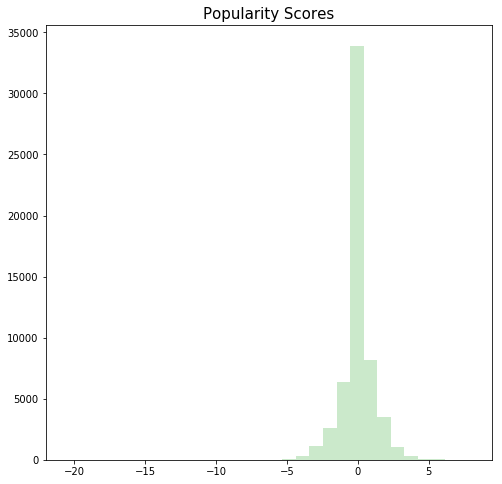

In [142]:
plt.figure(figsize=(8,8))
ax = sns.distplot(books_with_blurbs.PopularityScore, bins=30, kde=False, axlabel=False)
ax.set_title('Popularity Scores', fontsize=15)
plt.show()

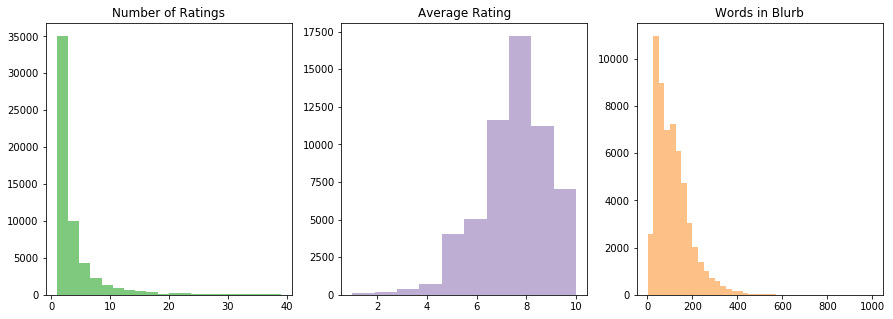

In [153]:
blurb_lengths = []
for blurb in books_with_blurbs.Blurb:
    leng = len(blurb.split())
    if leng < 1000:
        blurb_lengths.append(len(blurb.split()))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(books_with_blurbs.NumberRatings[books_with_blurbs.NumberRatings < 40], bins=20)
axes[0].set_title('Number of Ratings')

axes[1].hist(books_with_blurbs.AverageRating, bins=10, color=sns.color_palette()[1])
axes[1].set_title('Average Rating')

axes[2].hist(blurb_lengths, bins=40, color=sns.color_palette()[2])
axes[2].set_title('Words in Blurb')
plt.show()

In [7]:
# Initial modeling of data using Surprise Library

benchmark = []
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df_ratings.sample(frac=0.1), reader)

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.722188,40.269502,0.997177
SVD,1.727052,4.385387,0.364046
BaselineOnly,1.740657,0.638788,0.449563
KNNBaseline,1.742142,27.415883,0.610865
KNNBasic,1.839890,28.323796,0.825473
KNNWithMeans,1.849682,21.387417,0.637516
SlopeOne,1.855036,66.064480,1.643247
KNNWithZScore,1.858132,24.074101,0.824237
CoClustering,1.944520,12.523522,0.318774


Best algorithm is SVDpp, which is not significantly better than regular SVD and it has 10 times the runtime. Baseline is basically the same score as SVD, which means that our initial algorithm is not learning much at all.

In [157]:
1 - (len(df_ratings) / (len(df_ratings.ISBN.unique()) * len(df_ratings.User.unique())))

0.9999623775901277

Our current data is %99.996 sparse, which is extremely sparse. Sparsity is one of the major limitations of recommender systems. How can we reduce sparsity in our data?

<h2> BERT Vector Embeddings

How much contextual information do the BERT vectors of the blurbs on the back of the book provide? We Can use basic machine learning algorithms to test this.

In [192]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [163]:
books_with_blurbs_and_vectors.head()

,ISBN,Title,Author,Year,Publisher,Blurb,0,1,2,3,...,758,759,760,761,762,763,764,765,766,767
0,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",-0.576652,0.155099,0.168861,-0.318006,...,-0.221935,-0.029704,0.267414,-0.146690,-0.186485,0.078011,-0.071108,-0.058644,0.103595,0.099978
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea...",0.043223,0.001139,-0.198506,-0.023045,...,-0.207720,-0.029824,0.094324,-0.075062,0.003978,0.275549,-0.086969,-0.427712,0.001046,0.181398
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...,-0.229529,-0.135348,0.236877,-0.270375,...,-0.239951,-0.100915,-0.065937,-0.338876,-0.078111,0.218429,-0.090492,-0.143459,0.414473,0.176298
3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...,-0.138163,0.206053,0.192815,-0.110518,...,-0.230617,-0.147705,-0.109995,-0.055679,-0.419337,-0.150439,0.211348,-0.240285,0.224106,-0.240514
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...,-0.233292,-0.010518,0.260509,-0.180460,...,-0.361885,-0.224033,-0.118241,0.009988,-0.193690,0.058300,-0.107619,-0.308939,0.092318,-0.118852


Can the embeddings help us determine the year a book is published?

I split the data into two groups of roughly equal size: books published after 2001 and before 1989

In [226]:
books_with_blurbs_and_vectors = pd.read_csv('/DataScience/Final Capstone Files/books_with_blurbs_and_BERT_combined.csv')
books_with_blurbs_and_vectors.drop('Unnamed: 0', 1, inplace=True)

print('Size of new books:', len(books_with_blurbs_and_vectors[books_with_blurbs_and_vectors.Year > 2001]))
print('Size of old books:', len(books_with_blurbs_and_vectors[books_with_blurbs_and_vectors.Year < 1989]))

years = []
for year in books_with_blurbs_and_vectors.Year:
    if year > 2001:
        years.append(1)
    elif year < 1989:
        years.append(0)
    else:
        years.append(None)
books_with_blurbs_and_vectors['Year'] = years
X = books_with_blurbs_and_vectors.dropna()
Y = X.Year
X = X.iloc[:, 6:]

Size of new books: 9689
Size of old books: 9368


In [227]:
cv = 6
rfc = RandomForestClassifier(n_estimators=100)
results = cross_validate(rfc, X, Y, cv=cv)
print('Average accuracy with {}-fold cross validation:'.format(cv), results['test_score'].sum()/cv)

Average accuracy with 6-fold cross validation: 0.7139079172759325


%71 accuracy, compared to a baseline of %50. Not bad!

What about publisher? The most common publisher is Harlequin, so let's see if a random forest classifier can distinguish between a Harlequin blurb and an equal sized random sample of other blurbs.

In [209]:
books_with_blurbs_and_vectors = pd.read_csv('/DataScience/Final Capstone Files/books_with_blurbs_and_BERT_combined.csv')
books_with_blurbs_and_vectors.drop('Unnamed: 0', 1, inplace=True)
print('Number of books published by Harlequin:', len(books_with_blurbs_and_vectors[books_with_blurbs_and_vectors.Publisher == 'Harlequin']))
publishers = []
for publisher in books_with_blurbs_and_vectors.Publisher:
    if publisher == 'Harlequin':
        publishers.append(1)
    else:
        publishers.append(0)
books_with_blurbs_and_vectors['Publisher'] = publishers

X1 = books_with_blurbs_and_vectors[books_with_blurbs_and_vectors.Publisher == 1]
X2 = books_with_blurbs_and_vectors[books_with_blurbs_and_vectors.Publisher == 0].sample(1033)
X = pd.concat([X1, X2])
X = X.sample(frac=1)
Y = X.Publisher
X = X.iloc[:, 6:] 

Number of books published by Harlequin: 1033


In [225]:
cv = 6
rfc = RandomForestClassifier(n_estimators=100)
results = cross_validate(rfc, X, Y, cv=cv)
print('Average accuracy with {}-fold cross validation:'.format(cv), results['test_score'].sum()/cv)

Average accuracy with 6-fold cross validation: 0.884829950262132


%88 accuracy at detecting a Harlequin romance! That's only with 1000 examples as well. Baseline is 50% since we used an equal sample size of Harlequin and not.

What about Author? Our most prolific author is Stephen King. We only have 257 with blurbs.

In [229]:
print('Number of books written by Stephen King:', len(books_with_blurbs_and_vectors[books_with_blurbs_and_vectors.Author == 'Stephen King']))
books_with_blurbs_and_vectors = pd.read_csv('/DataScience/Final Capstone Files/books_with_blurbs_and_BERT_combined.csv')
books_with_blurbs_and_vectors.drop('Unnamed: 0', 1, inplace=True)

authors = []
for author in books_with_blurbs_and_vectors.Author:
    if author == 'Stephen King':
        authors.append(1)
    else:
        authors.append(0)
books_with_blurbs_and_vectors['Author'] = authors

X1 = books_with_blurbs_and_vectors[books_with_blurbs_and_vectors.Author == 1]
X2 = books_with_blurbs_and_vectors[books_with_blurbs_and_vectors.Author == 0].sample(len(X1))
X = pd.concat([X1, X2])
X = X.sample(frac=1)
Y = X.Author
X = X.iloc[:, 6:] 

Number of books written by Stephen King: 257


In [230]:
cv = 6
rfc = RandomForestClassifier(n_estimators=100)
results = cross_validate(rfc, X, Y, cv=cv)
print('Average accuracy with {}-fold cross validation:'.format(cv), results['test_score'].sum()/cv)

Average accuracy with 6-fold cross validation: 0.8055094130675525


Almost 81% accuracy with only 257 samples. This, along with the results for publisher and year stengthen the case that the BERT embeddings ARE providing contextual information about the books as they can reasonably predict meta-data. I think that most humans might perform worse than some of these benchmarks.

In [273]:
books_with_blurbs = pd.read_csv('/DataScience/Final Capstone Files/books_with_popularities.csv')
books_with_blurbs = pd.merge(books_with_blurbs, books_with_blurbs_and_vectors.drop(['Year', 'Publisher', 'Author'], 1))

print('Number of high rated books:', len(books_with_blurbs[books_with_blurbs.AverageRating > 8.5]))
print('Number of low rated books:', len(books_with_blurbs[books_with_blurbs.AverageRating < 7]))

ratings = []
for rating in books_with_blurbs.AverageRating:
    if rating > 8.5:
        ratings.append(1)
    elif rating < 7:
        ratings.append(0)
    else:
        ratings.append(None)
books_with_blurbs['AverageRating'] = ratings

X1 = books_with_blurbs[books_with_blurbs.AverageRating == 1]
X2 = books_with_blurbs[books_with_blurbs.AverageRating == 0]
X = pd.concat([X1, X2])
X = X.sample(frac=1)
Y = X.AverageRating
X = X.iloc[:, 9:] 

Number of high rated books: 13958
Number of low rated books: 13769


In [277]:
cv = 4
rfc = RandomForestClassifier(n_estimators=100)
results = cross_validate(rfc, X, Y, cv=cv)
print('Average accuracy with {}-fold cross validation:'.format(cv), results['test_score'].sum()/cv)

Average accuracy with 4-fold cross validation: 0.6001008591870729


Blurbs are much worse at indicating average rating.

In [284]:
books_with_blurbs = pd.read_csv('/DataScience/Final Capstone Files/books_with_popularities.csv')
books_with_blurbs = pd.merge(books_with_blurbs, books_with_blurbs_and_vectors.drop(['Year', 'Publisher', 'Author'], 1))

print('Number of books with 1 rating:', len(books_with_blurbs[books_with_blurbs.NumberRatings == 1]))
print('Number of books with 3 or more ratings:', len(books_with_blurbs[books_with_blurbs.NumberRatings > 2]))

ratings = []
for rating in books_with_blurbs.NumberRatings:
    if rating == 1:
        ratings.append(1)
    elif rating > 2:
        ratings.append(0)
    else:
        ratings.append(None)
books_with_blurbs['NumberRatings'] = ratings

X1 = books_with_blurbs[books_with_blurbs.NumberRatings == 1]
X2 = books_with_blurbs[books_with_blurbs.NumberRatings == 0]
X = pd.concat([X1, X2])
X = X.sample(frac=1)
Y = X.NumberRatings
X = X.iloc[:, 9:]

cv = 4
rfc = RandomForestClassifier(n_estimators=100)
results = cross_validate(rfc, X, Y, cv=cv)
print('Average accuracy with {}-fold cross validation:'.format(cv), results['test_score'].sum()/cv)

Number of books with 1 rating: 23420
Number of books with 3 or more ratings: 22455
Average accuracy with 4-fold cross validation: 0.639258779516449


Slightly better at predicting the number of ratings.